In [3]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import joypy
import random
from datetime import datetime, timedelta, timezone

from itertools import cycle

from scrape.api import DATETIME_FMT_STR
from scrape.graph import format_dataframe
from scrape.summary import get_rows_on_date
from scrape.summary import run as generate_summary
from scrape.graph import generate_plot_ci_lines

In [464]:
# Produce summary data
generate_summary(input_directory="data/national_fw48h", endpoint="national_fw48h", output_directory="data")
generate_summary(input_directory="data/national_pt24h", endpoint="national_pt24h", output_directory="data")

In [451]:
dffw = pd.read_csv("data/summary_national_fw48h.csv", index_col=0, header=[0,1])
dfpt = pd.read_csv("data/summary_national_pt24h.csv", index_col=0, header=[0,1])

# We don't get "actual" intensity from the fw48h endpoint
dffw = dffw.drop("intensity.actual", level=0, axis=1)

In [4]:
merged_df = pd.merge(dffw, dfpt, left_index=True, right_index=True, how="outer")
merged_df = format_dataframe(merged_df)
merged_df

NameError: name 'dffw' is not defined

<Axes: xlabel='time_difference'>

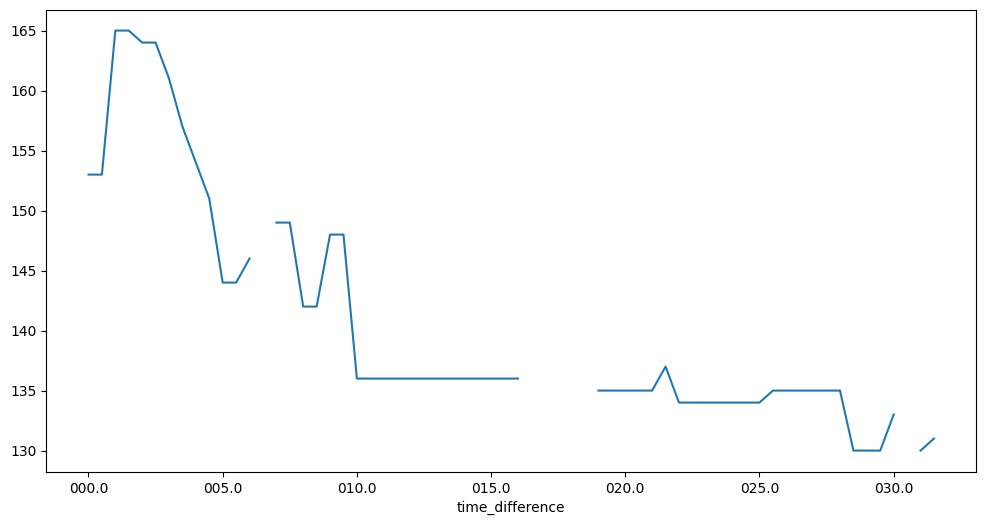

In [453]:
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

plt.figure()
dffw["intensity.forecast"].loc["2023-03-26T18:30Z"].plot()

We will show forecasts from 48 hours before the chosen start date, and also post-hoc "forecasts" and "actual" values taken for 24 hours after that date.

We do this for several hours' worth of data (several time-points) after the chosen start date:

Text(0.5, 1.0, 'Published CI values, 24 time windows 2023-03-28 09:30 - 2023-03-28 21:00 UTC')

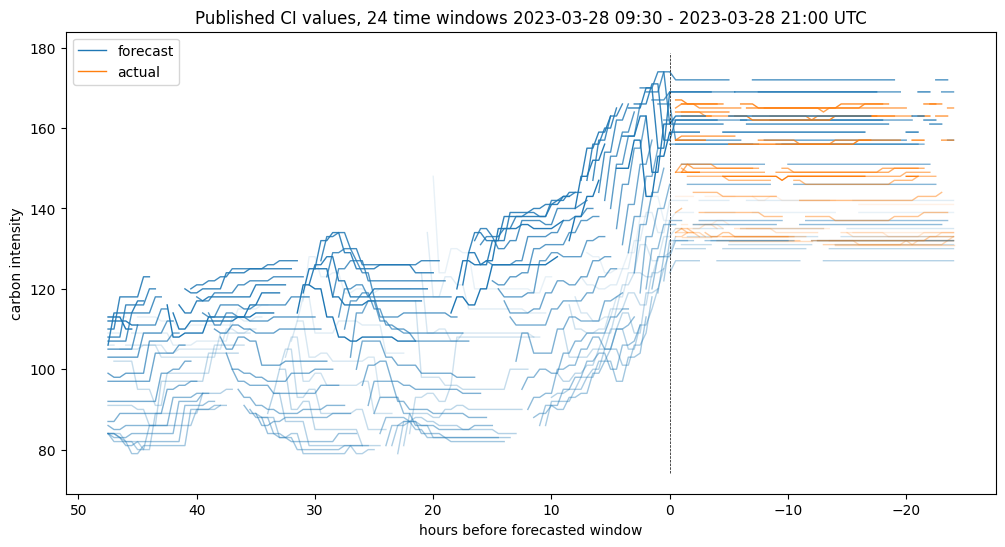

In [478]:
# Same as the below but on one plot with increasing opacity to indicate more recent values

# Want to show N hours of data. The most recent timepoint for which all data is available will be now - 24 hours.
# The first timepoint will be now - 24 hours - N hours.
hours_of_data = 12
hours_prior_to_now = 24 + hours_of_data
dt_pastpoint = datetime.now(tz=timezone.utc) - timedelta(hours=hours_prior_to_now)

# pick datetimes
nplots = hours_of_data * 2
dates = [d for d in merged_df.index if d >= dt_pastpoint][:nplots]

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

# Don't start from 0 for opacity
alphas = iter(np.linspace(0.1, 1, len(dates)))

colours = cycle(["tab:blue", "tab:orange"])

def ftime(dt):
    return datetime.strftime(dt, "%Y-%m-%d %H:%M")

fig, ax = plt.subplots(1, 1)
for ix, dt in enumerate(dates):
    alpha = next(alphas)
    
    # set label to empty string unless it is the last iteration
    plot_defs = {"ax": ax, "linewidth": 1, "alpha": alpha, "label": ""}
    if dt == dates[-1]:
        plot_defs["label"] = "forecast"
    
    plot_defs["c"] = next(colours)
    fct = merged_df["intensity.forecast"].loc[dt].plot(**plot_defs)
    
    if dt == dates[-1]:
        plot_defs["label"] = "actual"
    plot_defs["c"] = next(colours)
    act = merged_df["intensity.actual"].loc[dt].plot(**plot_defs)
    
    if dt == dates[-1]:
        ax.legend()

        
ax.vlines(0.0,ax.get_ylim()[0],ax.get_ylim()[-1], color='k', linestyle='--', linewidth=0.5)
plt.gca().invert_xaxis()

ax.set_xlabel("hours before forecasted window")
ax.set_ylabel("carbon intensity")

ax.set_title(f"Published CI values, {len(dates)} time windows {ftime(dates[0])} - {ftime(dates[-1])} UTC")

In [332]:
hours_prior_to_now = 48

dt_now = datetime.now(tz=timezone.utc).strftime(DATETIME_FMT_STR)
dt_pastpoint = datetime.now(tz=timezone.utc) - timedelta(hours=hours_prior_to_now)
hours_of_data = 12

print(f"Date now: {dt_now}\nStart date for analysis: {dt_pastpoint}")

Date now: 2023-03-29T18:46Z
Start date for analysis: 2023-03-27 18:46:30.295061+00:00


Will plot 24 half-hourly timepoints starting from 36 hours ago, 2023-03-28 08:39:19.050864+00:00


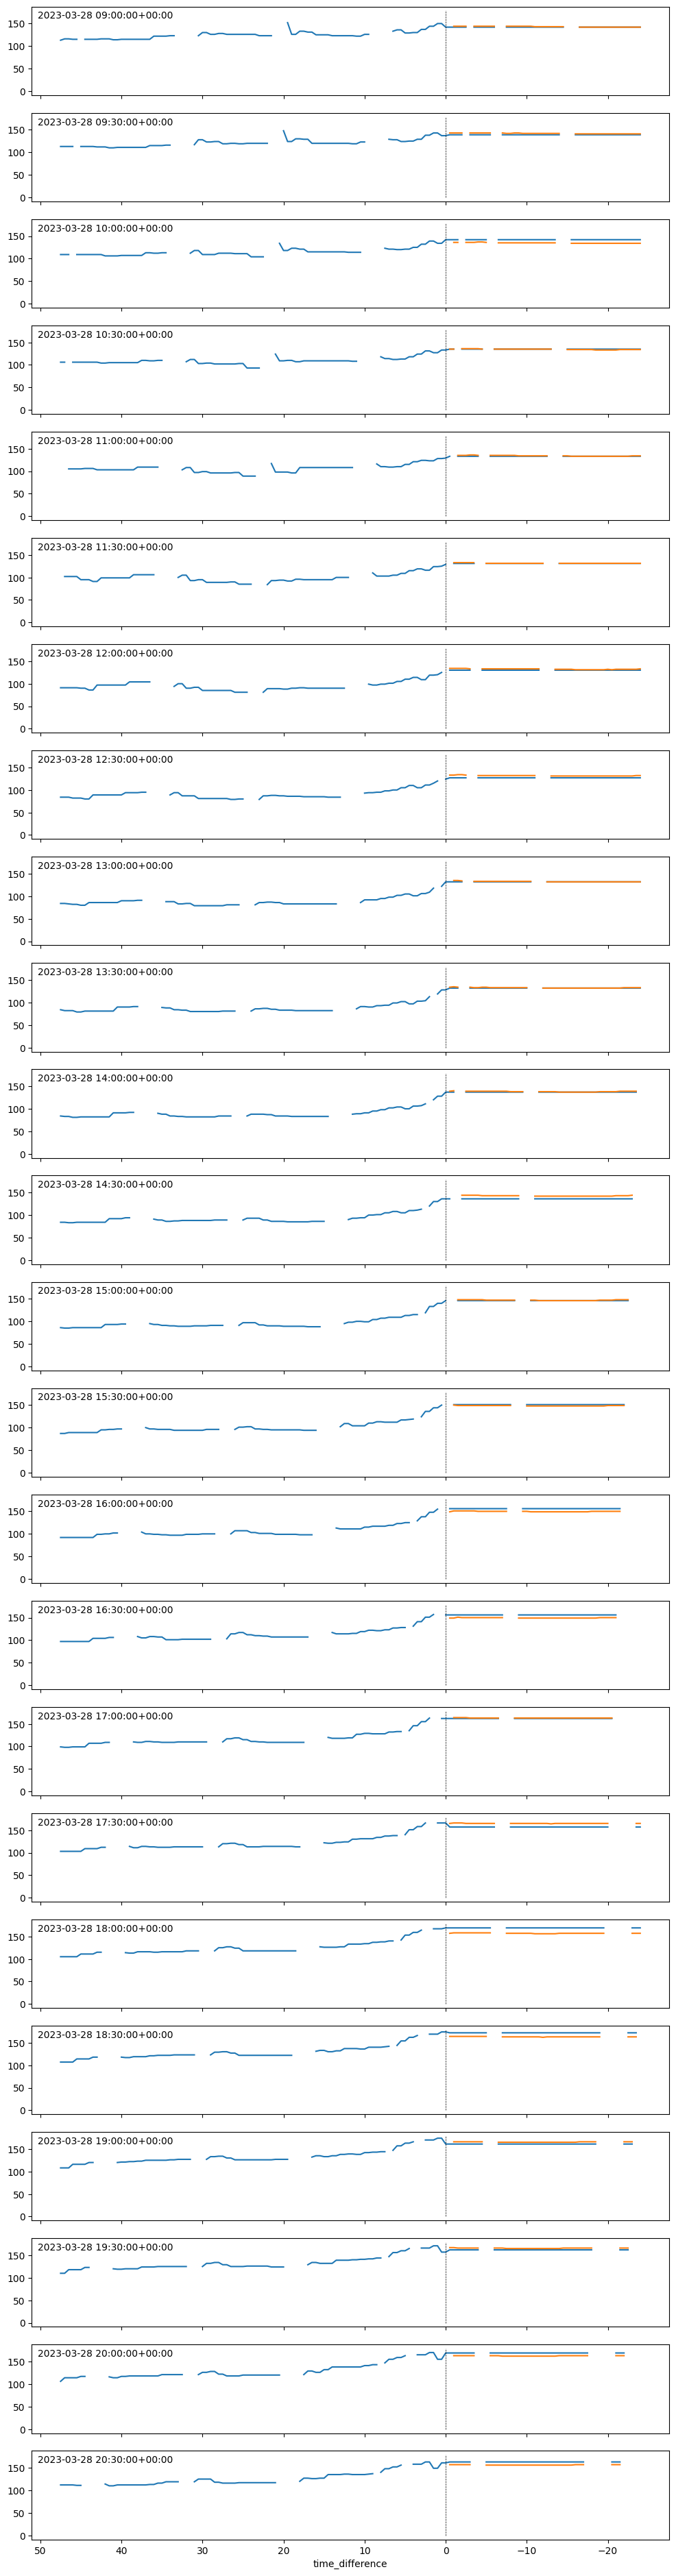

In [476]:
# Time-points are half-hourly so need twice the rows as hours covered
nrows = hours_of_data * 2
dates = [d for d in merged_df.index if d >= dt_pastpoint][:nrows]
print(f"Will plot {nrows} half-hourly timepoints starting from {hours_prior_to_now} hours ago, {dt_pastpoint}")

# Alternatively plot some random dates
# dates = random.choices(merged_df.index, k=nrows)

plt.rcParams['figure.figsize'] = [12, 48]
plt.rcParams['figure.dpi'] = 100

fig, axes = plt.subplots(nrows, 1, sharex=True, sharey="col")
for ix, ax in enumerate(axes):
    merged_df["intensity.forecast"].loc[dates[ix]].plot(ax=ax)
    merged_df["intensity.actual"].loc[dates[ix]].plot(ax=ax)
    ax.text(0.01, 0.95, dates[ix], horizontalalignment='left', verticalalignment='top', transform = ax.transAxes)
    
plt.gca().invert_xaxis()
ymax = plt.gca().get_ylim()[-1]

for ix, ax in enumerate(axes):
    ax.vlines(0.0,0,ymax, color='k', linestyle='--', linewidth=0.5)

Odd in the above that the post-hoc "forecast" value appears to be constant after about 30 minutes after the selected time-point, but the "actual" value continues to change.

The final forecast value doesn't appear until about 30 minutes after the start of the window; same with the "actual" value, which is only available after the end of the given window.

In [334]:
# Use only forecasts for measuring prediction quality

forecast_df = format_dataframe(dffw)

[Timestamp('2023-03-28 09:30:00+0000', tz='UTC'), Timestamp('2023-03-28 10:00:00+0000', tz='UTC'), Timestamp('2023-03-28 10:30:00+0000', tz='UTC'), Timestamp('2023-03-28 11:00:00+0000', tz='UTC'), Timestamp('2023-03-28 11:30:00+0000', tz='UTC'), Timestamp('2023-03-28 12:00:00+0000', tz='UTC'), Timestamp('2023-03-28 12:30:00+0000', tz='UTC'), Timestamp('2023-03-28 13:00:00+0000', tz='UTC'), Timestamp('2023-03-28 13:30:00+0000', tz='UTC'), Timestamp('2023-03-28 14:00:00+0000', tz='UTC'), Timestamp('2023-03-28 14:30:00+0000', tz='UTC'), Timestamp('2023-03-28 15:00:00+0000', tz='UTC'), Timestamp('2023-03-28 15:30:00+0000', tz='UTC'), Timestamp('2023-03-28 16:00:00+0000', tz='UTC'), Timestamp('2023-03-28 16:30:00+0000', tz='UTC'), Timestamp('2023-03-28 17:00:00+0000', tz='UTC'), Timestamp('2023-03-28 17:30:00+0000', tz='UTC'), Timestamp('2023-03-28 18:00:00+0000', tz='UTC'), Timestamp('2023-03-28 18:30:00+0000', tz='UTC'), Timestamp('2023-03-28 19:00:00+0000', tz='UTC'), Timestamp('2023-03-

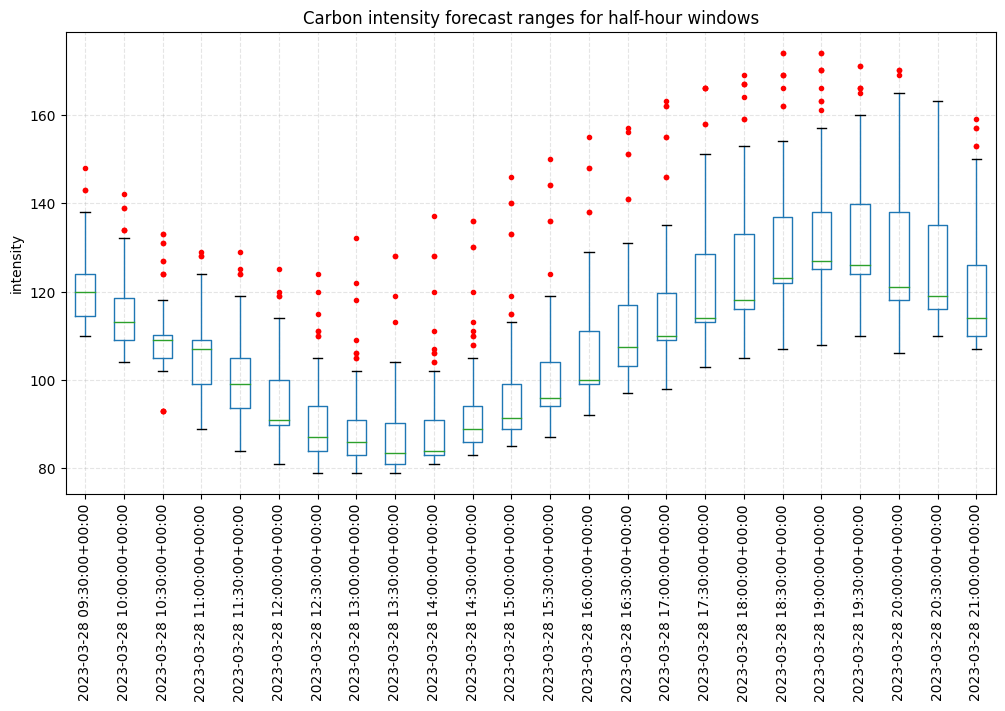

In [497]:
# Boxplots for all of the forecasts for a list of given windows

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

print(dates)
ax = forecast_df["intensity.forecast"].loc[dates].T.boxplot(rot=90, sym='r.')
ax.set_title("Carbon intensity forecast ranges for half-hour windows")
ax.set_ylabel("intensity")
ax.grid('on', linestyle='--', alpha=0.33)

In [488]:
# Get the earliest time from the day a week ago
now = datetime.now(tz=timezone.utc)
dt = now - timedelta(days=7)
dt = datetime(dt.year, dt.month, dt.day, 0, 0, 0).astimezone(timezone.utc)

In [489]:
# Individual days (about 48 forecasts per day)
x = get_rows_on_date(forecast_df["intensity.forecast"], dt)
x = get_rows_on_date(forecast_df["intensity.forecast"], now)

In [490]:
# All days from then to now
df_fore = forecast_df.loc[dt:now]["intensity.forecast"].copy()
df_fore.index = df_fore.index.date
df_fore

time_difference,47.5,47.0,46.5,46.0,45.5,45.0,44.5,44.0,43.5,43.0,...,4.5,4.0,3.5,3.0,2.5,2.0,1.5,1.0,0.5,0.0
2023-03-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,79.0,109.0,109.0,91.0,92.0,91.0,84.0,78.0,78.0,NaN
2023-03-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,89.0,89.0,89.0,89.0,89.0,81.0,74.0,74.0,NaN,NaN
2023-03-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,86.0,86.0,87.0,86.0,78.0,74.0,74.0,NaN,NaN,NaN
2023-03-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,84.0,84.0,83.0,75.0,71.0,71.0,NaN,NaN,NaN,61.0
2023-03-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,83.0,83.0,73.0,71.0,71.0,NaN,NaN,NaN,59.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-29,111.0,111.0,111.0,111.0,111.0,112.0,112.0,111.0,111.0,NaN,...,NaN,118.0,NaN,NaN,NaN,108.0,108.0,114.0,NaN,NaN
2023-03-29,108.0,108.0,108.0,108.0,109.0,109.0,109.0,109.0,NaN,NaN,...,114.0,NaN,NaN,NaN,105.0,105.0,112.0,NaN,NaN,NaN
2023-03-29,108.0,108.0,108.0,108.0,108.0,108.0,108.0,NaN,NaN,NaN,...,NaN,NaN,NaN,99.0,99.0,107.0,NaN,NaN,NaN,NaN
2023-03-29,102.0,102.0,103.0,103.0,103.0,103.0,NaN,NaN,NaN,101.0,...,NaN,NaN,101.0,101.0,104.0,NaN,NaN,NaN,NaN,NaN


### Comparison with "actual"

Take a single value as the "actual" intensity for a given window.

In [491]:
# Get the final (rightmost, assuming we have -24.0 as the rightmost) non-NaN value in each row
merged_df["intensity.actual.final"] = merged_df["intensity.actual"].ffill(axis=1).iloc[:, -1]

# test it works:
merged_df.iloc[640:650]

intensity.forecast                                \
time_difference                         47.5 47.0 46.5 46.0 45.5 45.0 44.5   
2023-03-26 11:00:00+00:00                NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2023-03-26 11:30:00+00:00                NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2023-03-26 12:00:00+00:00                NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2023-03-26 12:30:00+00:00                NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2023-03-26 13:00:00+00:00                NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2023-03-26 13:30:00+00:00                NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2023-03-26 14:00:00+00:00                NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2023-03-26 14:30:00+00:00                NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2023-03-26 15:00:00+00:00                NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2023-03-26 15:30:00+00:00                NaN  NaN  NaN  NaN  NaN  NaN  NaN   

                                          ... intensity.actual                \
time_difference           44.0 43.5 43.0  ...            -20.0  -20.5  -21.0   
2023-03-26 11:00:00+00:00  NaN  NaN  NaN  ...            113.0  113.0  113.0   
2023-03-26 11:30:00+00:00  NaN  NaN  NaN  ...            115.0  115.0  115.0   
2023-03-26 12:00:00+00:00  NaN  NaN  NaN  ...            112.0  112.0  112.0   
2023-03-26 12:30:00+00:00  NaN  NaN  NaN  ...            113.0  113.0  113.0   
2023-03-26 13:00:00+00:00  NaN  NaN  NaN  ...            117.0  117.0  116.0   
2023-03-26 13:30:00+00:00  NaN  NaN  NaN  ...            122.0  121.0  121.0   
2023-03-26 14:00:00+00:00  NaN  NaN  NaN  ...            129.0  129.0  129.0   
2023-03-26 14:30:00+00:00  NaN  NaN  NaN  ...            132.0  132.0  132.0   
2023-03-26 15:00:00+00:00  NaN  NaN  NaN  ...            135.0  135.0    NaN   
2023-03-26 15:30:00+00:00  NaN  NaN  NaN  ...            140.0    NaN    NaN   

                                                                     \
time_difference            -21.5  -22.0  -22.5  -23.0  -23.5  -24.0   
2023-03-26 11:00:00+00:00  113.0  113.0  113.0  114.0  114.0  114.0   
2023-03-26 11:30:00+00:00  115.0  115.0  115.0  115.0  115.0  115.0   
2023-03-26 12:00:00+00:00  112.0  112.0  112.0  112.0  112.0    NaN   
2023-03-26 12:30:00+00:00  112.0  112.0  112.0  112.0    NaN    NaN   
2023-03-26 13:00:00+00:00  116.0  116.0  116.0    NaN    NaN    NaN   
2023-03-26 13:30:00+00:00  121.0  121.0    NaN    NaN    NaN  123.0   
2023-03-26 14:00:00+00:00  129.0    NaN    NaN    NaN  129.0  130.0   
2023-03-26 14:30:00+00:00    NaN    NaN    NaN  132.0  132.0  132.0   
2023-03-26 15:00:00+00:00    NaN    NaN  135.0  135.0  135.0  136.0   
2023-03-26 15:30:00+00:00    NaN  140.0  140.0  140.0  140.0  140.0   

                          intensity.actual.final  
time_difference                                   
2023-03-26 11:00:00+00:00                  114.0  
2023-03-26 11:30:00+00:00                  115.0  
2023-03-26 12:00:00+00:00                  112.0  
2023-03-26 12:30:00+00:00                  112.0  
2023-03-26 13:00:00+00:00                  116.0  
2023-03-26 13:30:00+00:00                  123.0  
2023-03-26 14:00:00+00:00                  130.0  
2023-03-26 14:30:00+00:00                  132.0  
2023-03-26 15:00:00+00:00                  136.0  
2023-03-26 15:30:00+00:00                  140.0  

[10 rows x 193 columns]

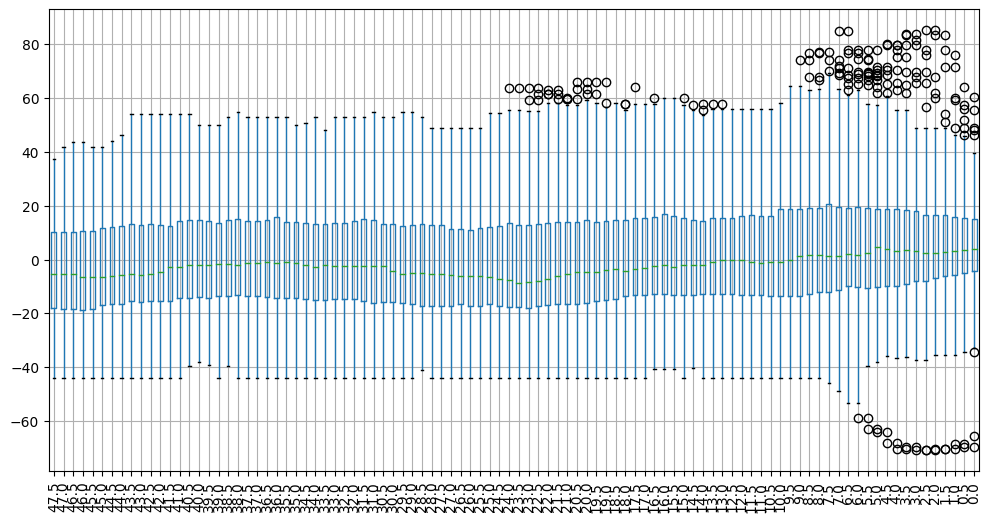

In [492]:
dff = merged_df.loc[dt:now][["intensity.forecast", "intensity.actual.final"]].copy()

# Percentage err
dfferr = 100. * (dff["intensity.forecast"].sub(dff["intensity.actual.final"], axis=0)).div(dff["intensity.actual.final"], axis=0)
# only pre-timepoint forecasts
dfferr = dfferr[[c for c in dfferr.columns if float(c) >= 0.0]]

ax = dfferr.boxplot(rot=90)

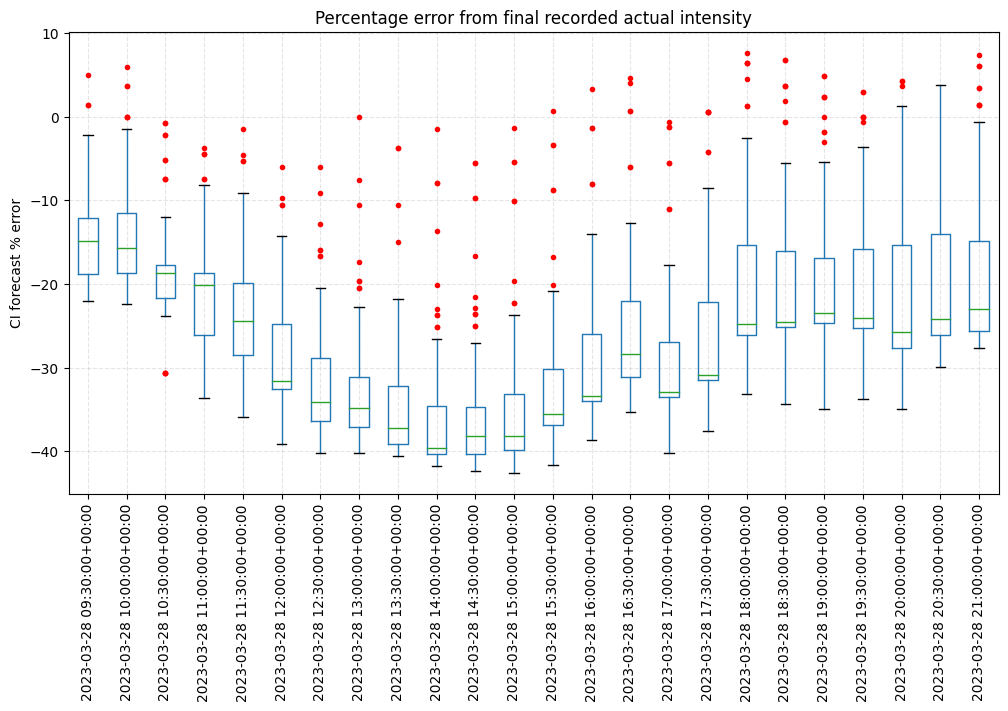

In [498]:
ax = dfferr.loc[dates].T.boxplot(rot=90, sym='r.')
ax.set_title("Percentage error from final recorded actual intensity")
ax.set_ylabel("CI forecast % error")
ax.grid('on', linestyle='--', alpha=0.33)

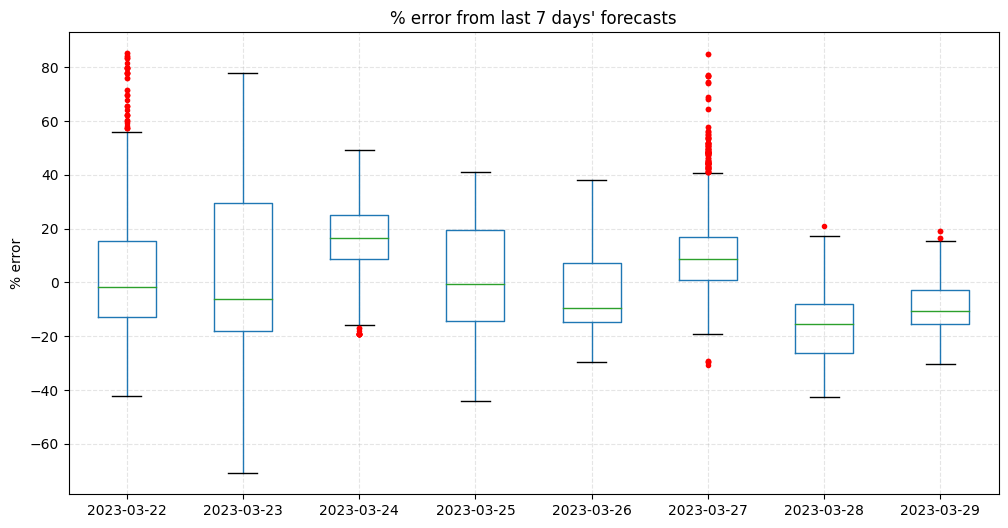

In [343]:
# All days from then to now
dff = dfferr.loc[dt:now].copy()
dff.index = dff.index.date

# Boxplot summary for a whole day:
# combine all forecasts for that day; don't worry about the number of hours before the window they came from.

forecast_cols = dff.columns

# Add a helper column to count occurrences of each label
dff['count_per_day'] = dff.groupby(dff.index).cumcount()
# pivot into a multiindex
result = dff.pivot_table(index=dff.index, columns='count_per_day', values=list(forecast_cols), aggfunc='first')
# flatten
result.columns = [f'{level1}_{level2+1}' for level1, level2 in result.columns]
# fix, ax = plt.figure("% error on final actual CI value")
ax = result.T.boxplot(sym='r.')
ax.set_title("% error from last 7 days' forecasts")
ax.set_ylabel("% error")
ax.grid('on', linestyle='--', alpha=0.33)

In [344]:
# Alternative single "actual" values from the mean and median.

merged_df["actual"] = merged_df["intensity.actual"].mean(axis=1)
merged_df["actual_median"] = merged_df["intensity.actual"].median(axis=1)

dfif = merged_df["intensity.forecast"]

df_forecasts_posthoc = dfif[[c for c in dfif.columns if float(c) < 0.0]]
merged_df["actual_forecast"] = df_forecasts_posthoc[-1.0]

In [345]:
dfsub = merged_df["intensity.forecast"].sub(merged_df["actual"], axis=0)
dfsub_pc = dfsub / merged_df["intensity.forecast"]

dfsub_forecasts = merged_df["intensity.forecast"].sub(merged_df["actual_forecast"], axis=0)
dfsub_fc_pc = dfsub_forecasts / merged_df["intensity.forecast"]

The following Joy / Ridgeline plots are histograms taken across all available data.

For each of the 96 half-hourly timepoints prior to any given target window, we count into a histogram bin if the forecast has this much % error from the final forecast or mean "actual" value (which, confusingly, can change).

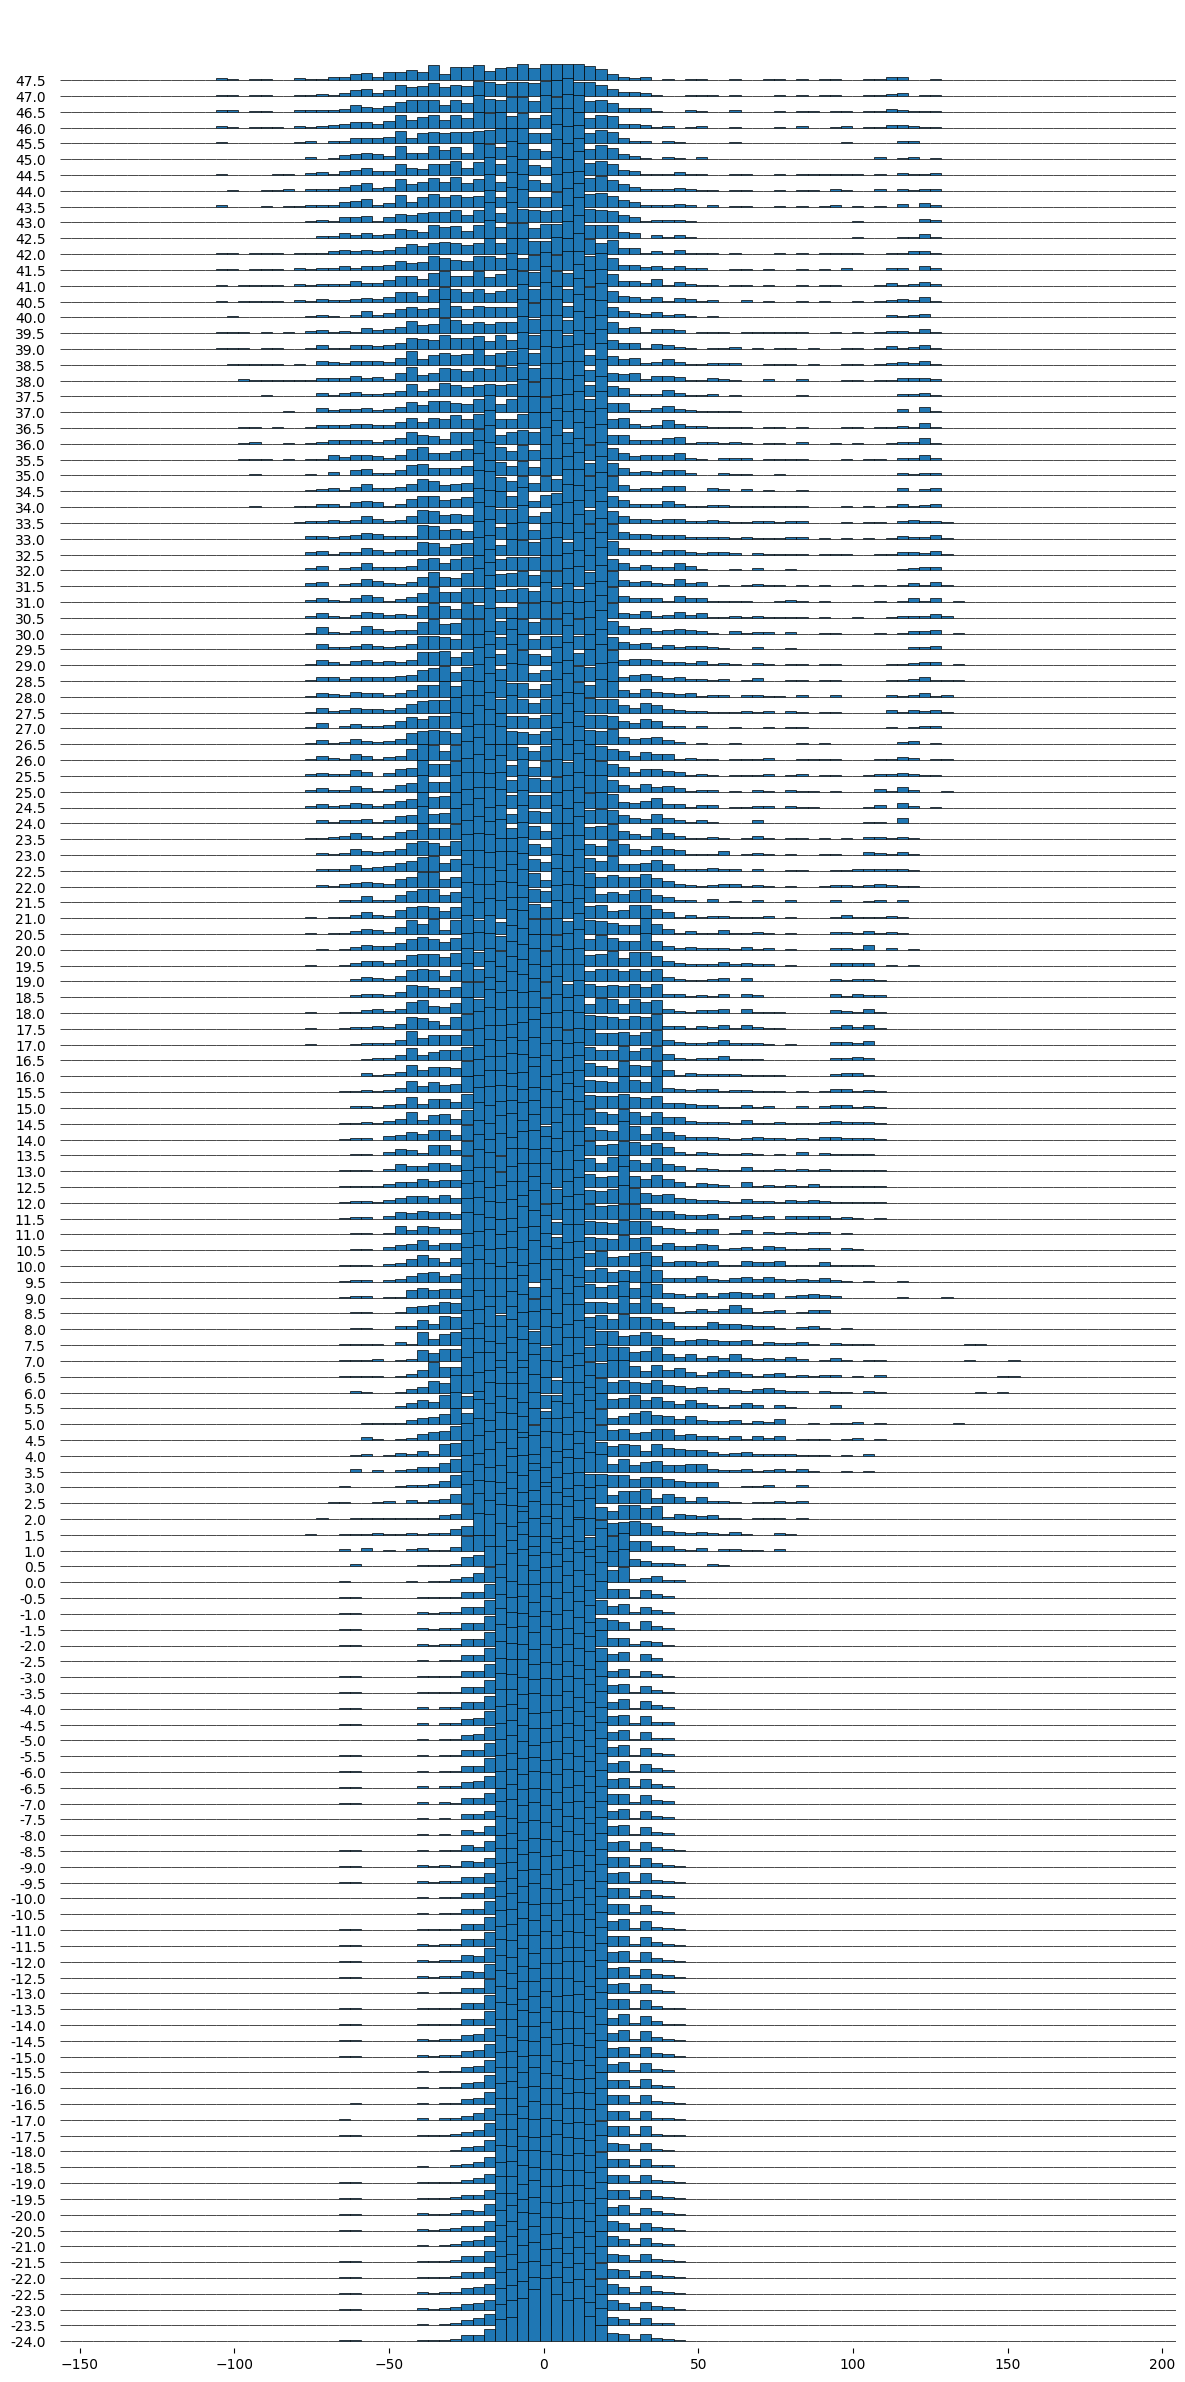

In [346]:
plt.rcParams['figure.figsize'] = [12, 24]
plt.rcParams['figure.dpi'] = 100

# Plot histograms of the actual data differences
# fig, ax = joypy.joyplot(dfsub, linewidth=0.5)
fig, ax = joypy.joyplot(dfsub, hist=True, bins=100, linewidth=0.5)

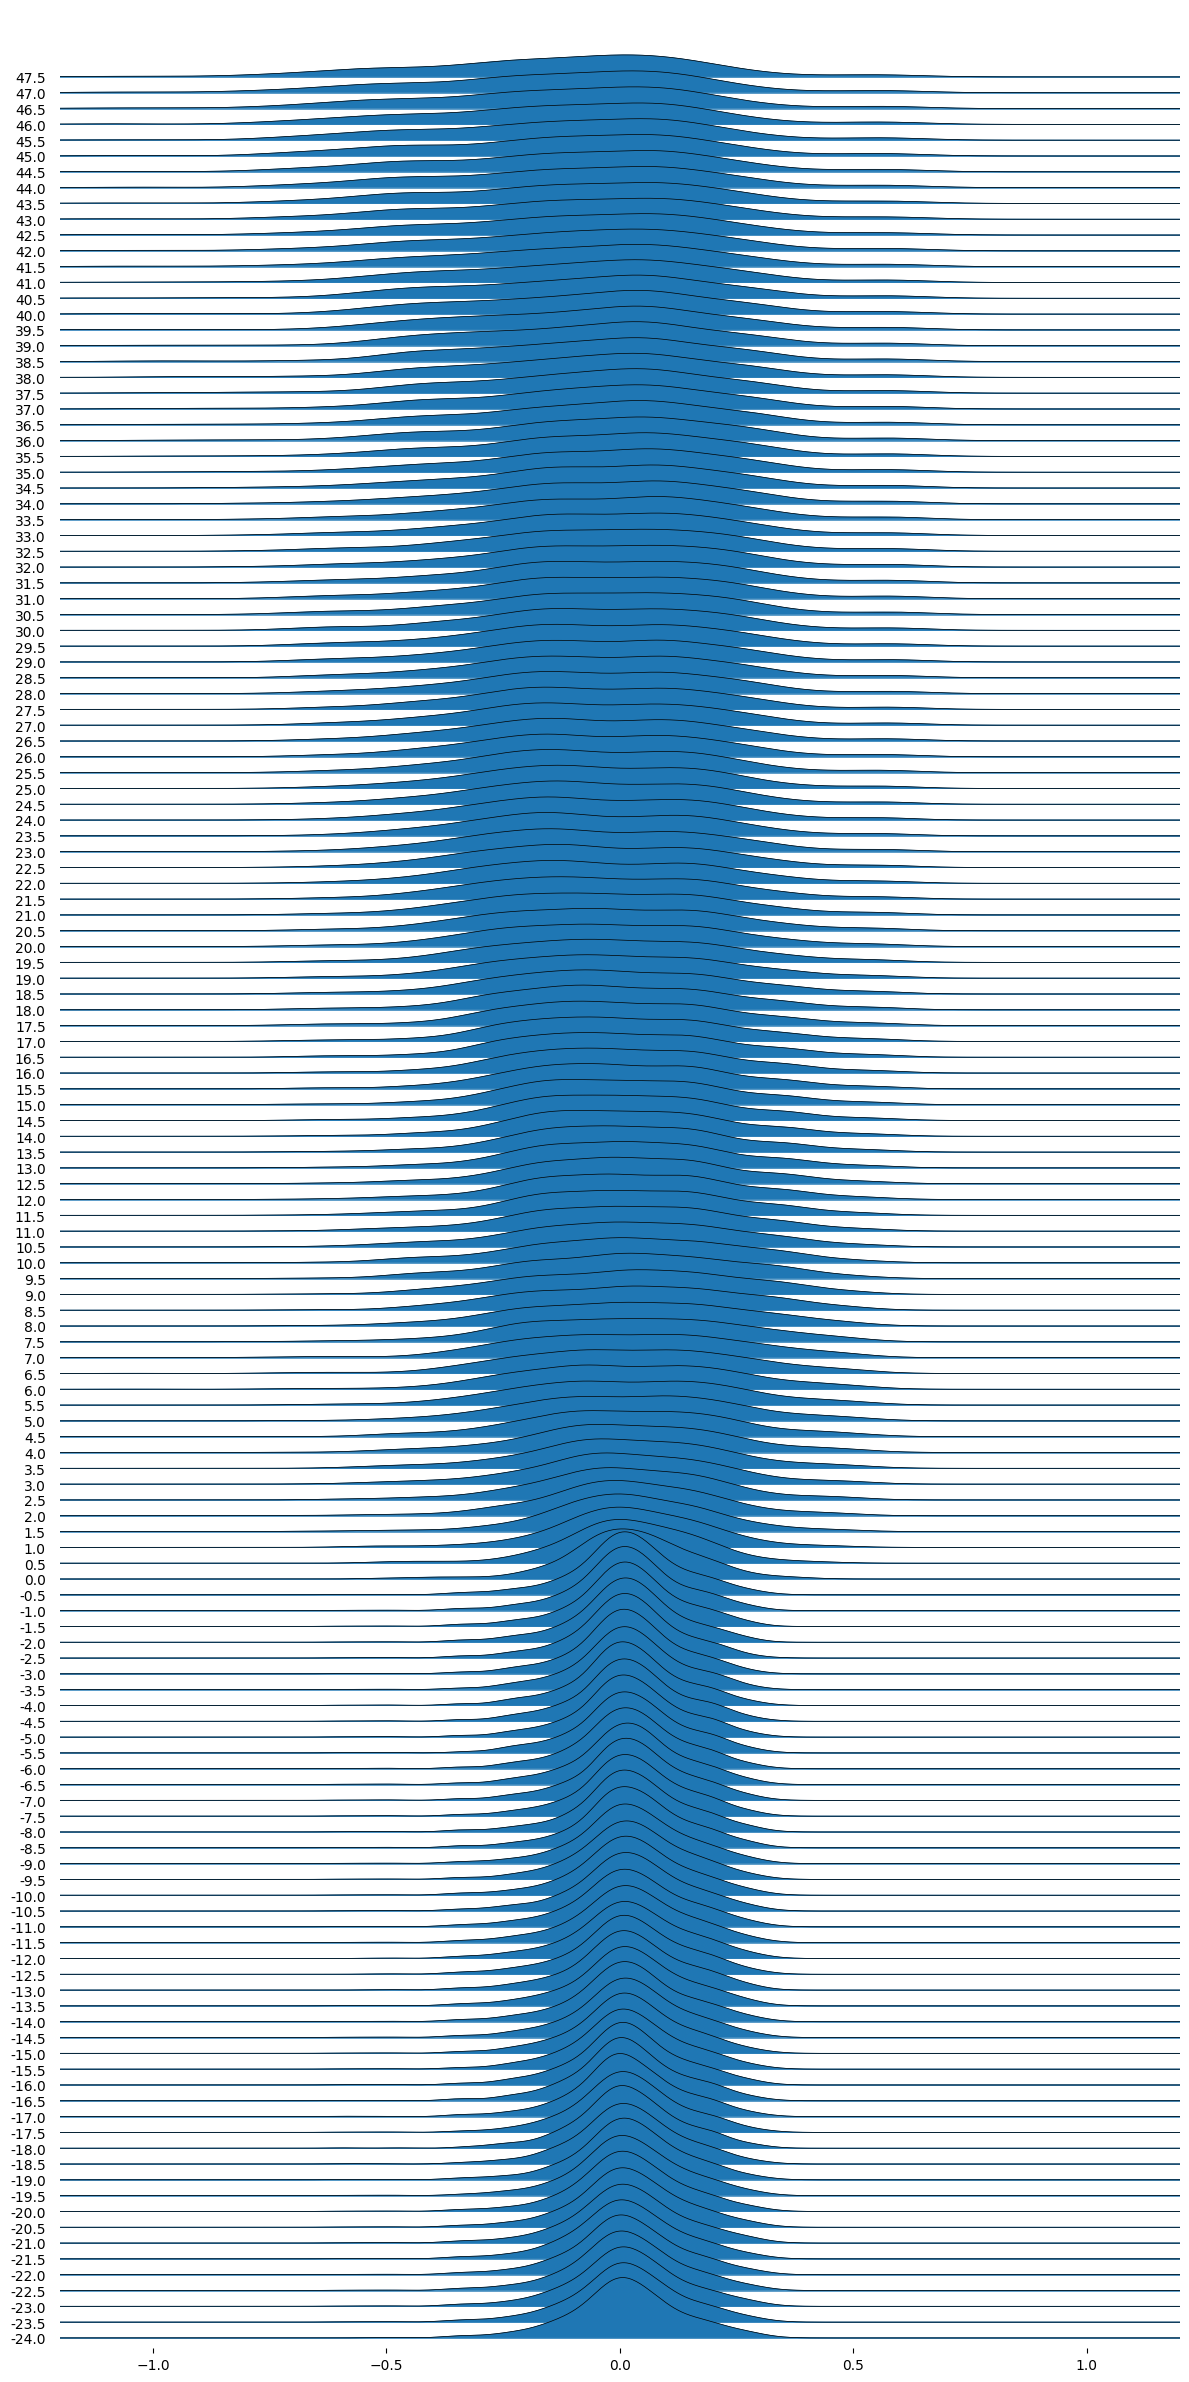

In [347]:
# Show a smoothed plot of the relative difference between the forecast and the mean "actual" value after.
fig, axes = joypy.joyplot(dfsub_pc, linewidth=0.5)
for ax in axes:
    ax.set_xlim(-1.2, 1.2)

/Users/nick.powell/.virtualenvs/carbon-intensity-forecast-tracking/lib/python3.10/site-packages/joypy/joyplot.py:286: UserWarning: The data contains a group with a single distinct value (0.0) having infinite probability density. Consider using a different visualization.
  warnings.warn("The data contains a group with a single distinct value ({}) "


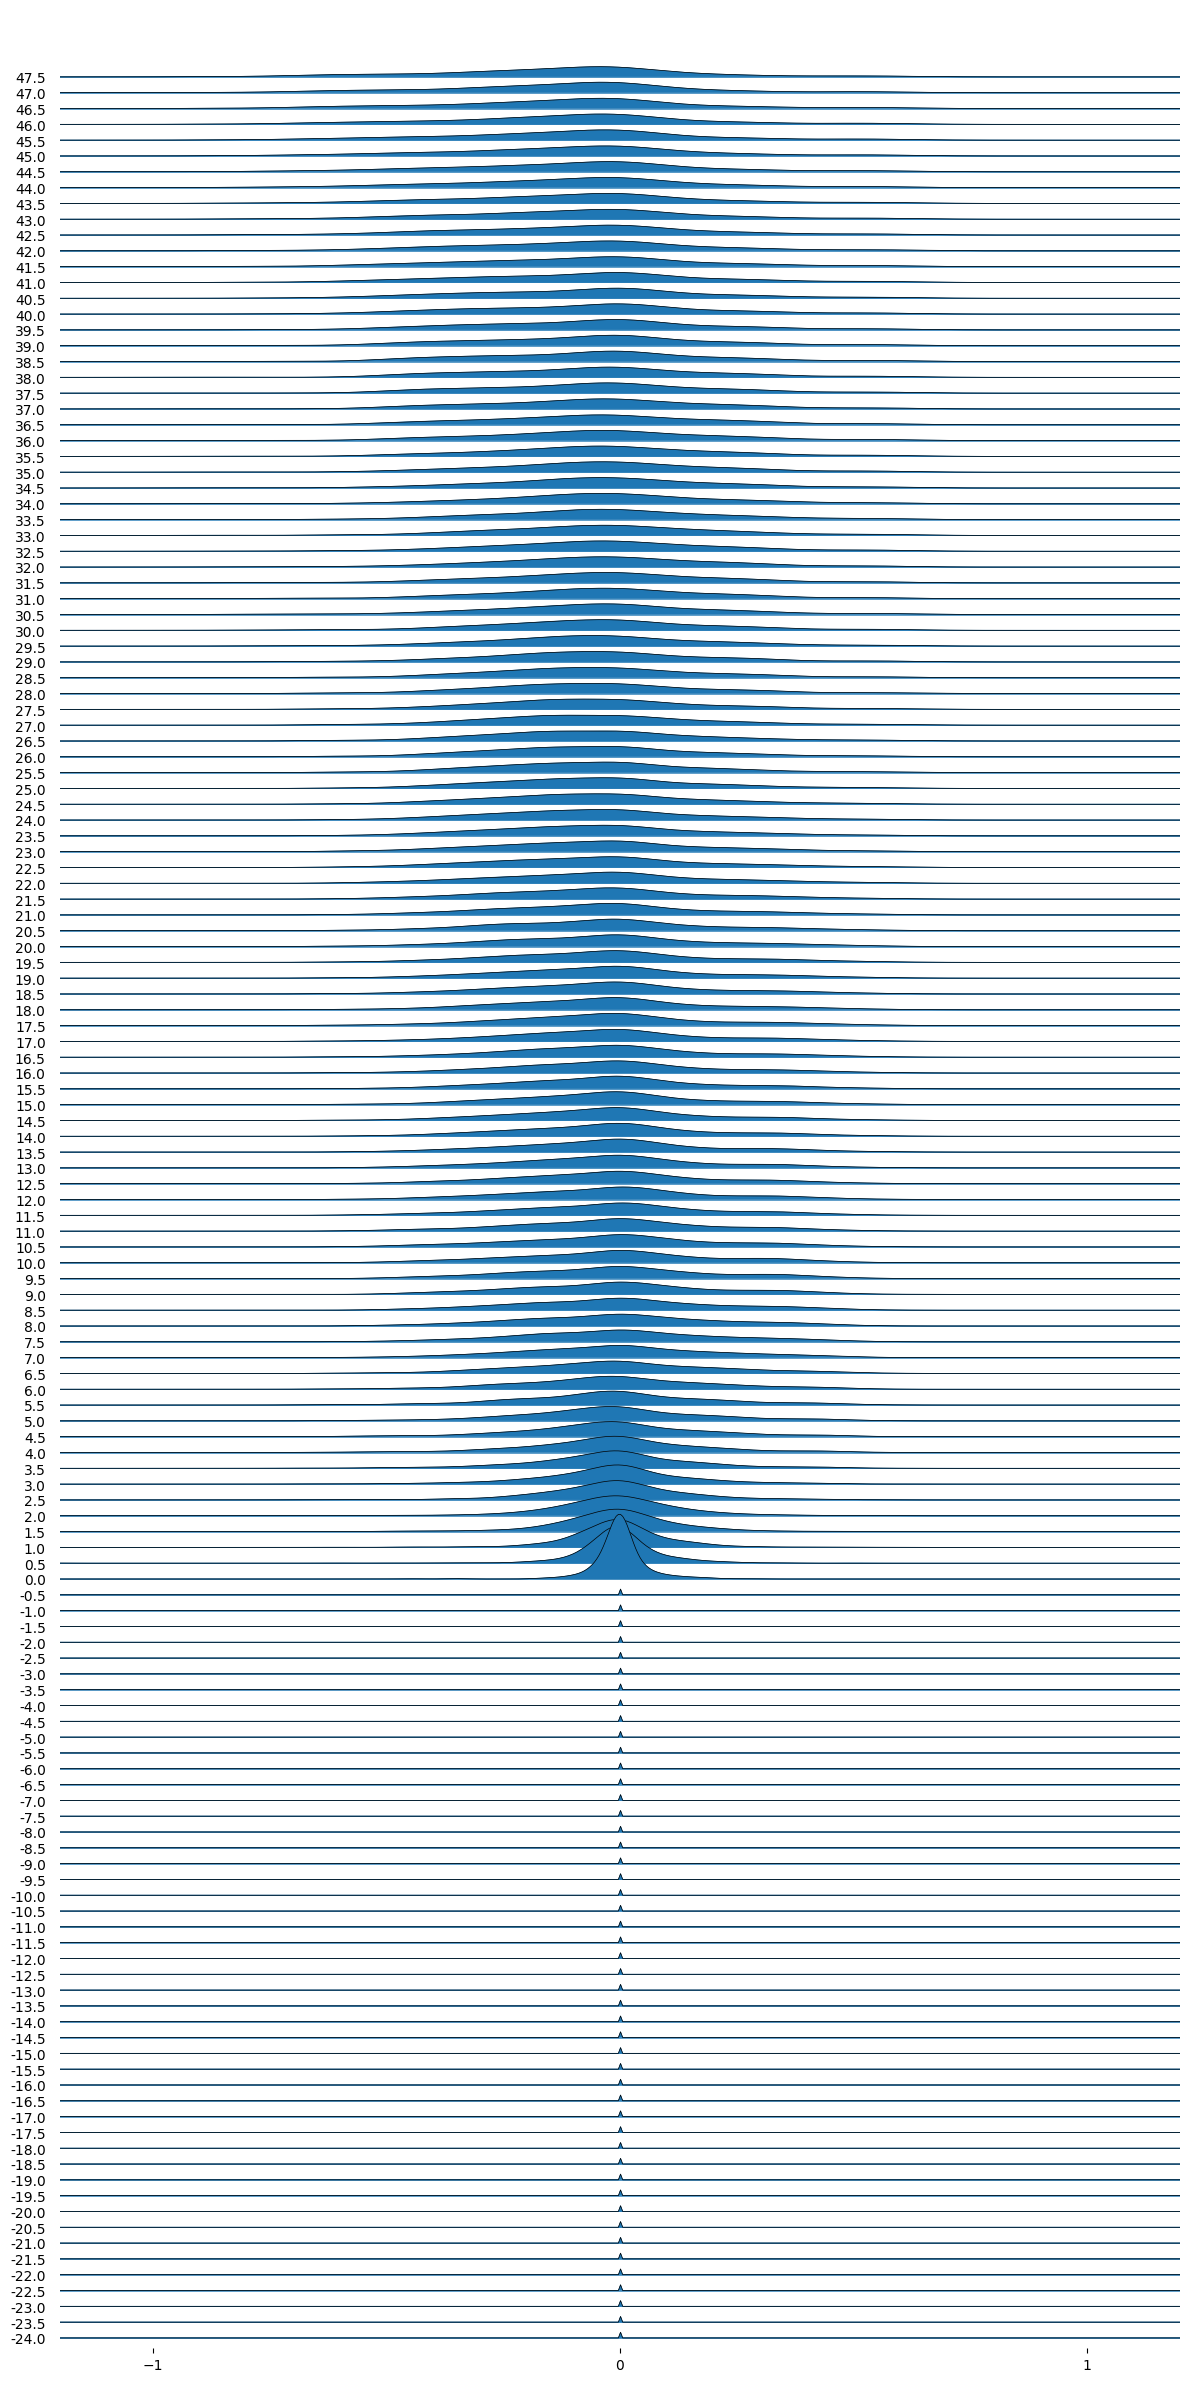

In [348]:
fig, axes = joypy.joyplot(dfsub_fc_pc, linewidth=0.5)
for ax in axes:
    ax.set_xlim(-1.2, 1.2)

In the above, we show that forecasts are _not great_. A deviation of +/- 1.0 represents a 100% error on the actual value. We can also show the mean and standard deviation percentage errors for each forecasting half-hour.

In [349]:
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

(48.0, -24.0)

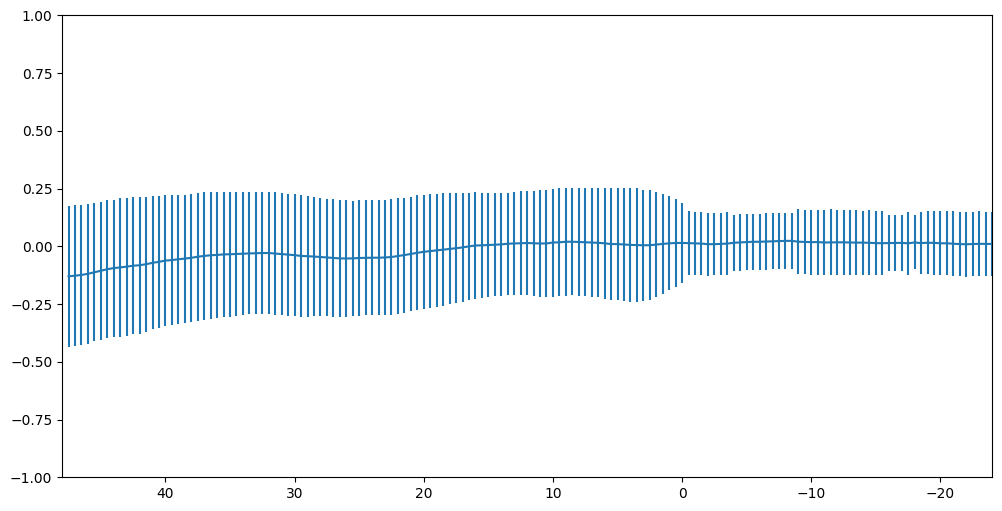

In [350]:
means = pd.DataFrame(dfsub_pc.mean(axis=0)).rename(columns={0: "mean"})
stdevs = pd.DataFrame(dfsub_pc.std(axis=0)).rename(columns={0: "stdev"})
mean_std = pd.concat([means, stdevs], axis=1).reset_index()
mean_std = mean_std.apply(pd.to_numeric, errors='coerce')
ax = plt.errorbar("time_difference", "mean", yerr="stdev", data=mean_std)
plt.ylim(-1., 1.)
plt.xlim(48., -24.)

(48.0, -24.0)

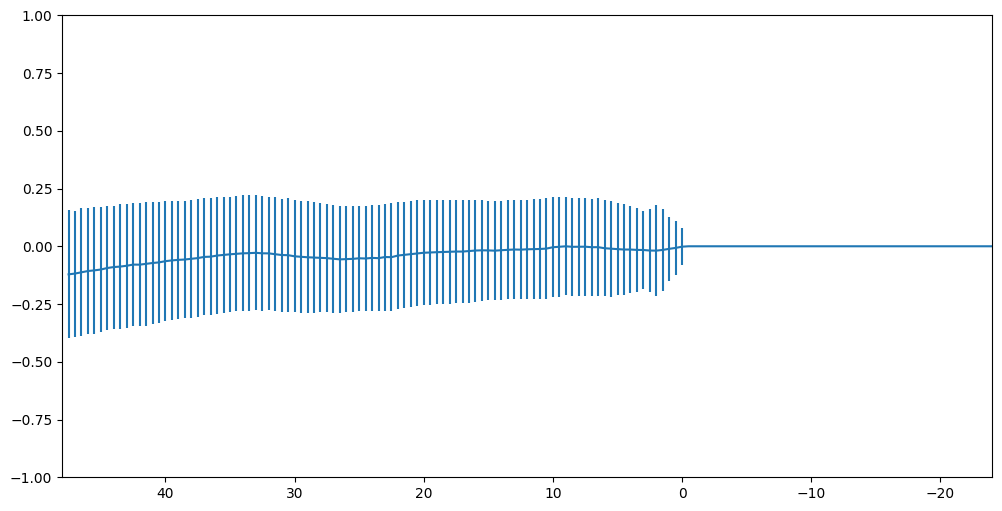

In [351]:
means = pd.DataFrame(dfsub_fc_pc.mean(axis=0)).rename(columns={0: "mean"})
stdevs = pd.DataFrame(dfsub_fc_pc.std(axis=0)).rename(columns={0: "stdev"})
mean_std = pd.concat([means, stdevs], axis=1).reset_index()
mean_std = mean_std.apply(pd.to_numeric, errors='coerce')
ax = plt.errorbar("time_difference", "mean", yerr="stdev", data=mean_std)
plt.ylim(-1., 1.)
plt.xlim(48., -24.)

time_difference
 47.5    30.447221
 47.0    30.459752
 46.5    30.282062
 46.0    30.192296
 45.5    29.927214
           ...    
-22.0    13.983788
-22.5    13.965334
-23.0    14.003116
-23.5    14.017037
-24.0    13.825324
Length: 144, dtype: float64


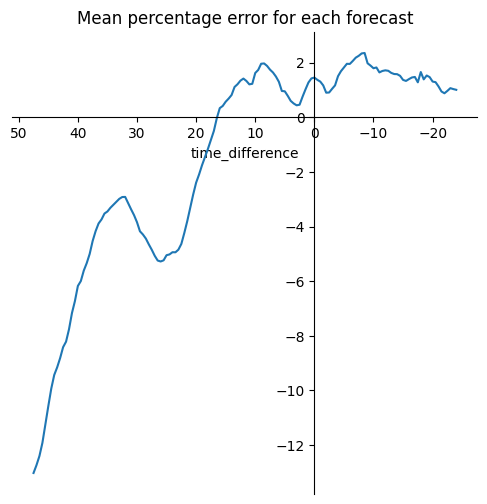

In [500]:
plt.rcParams['figure.figsize'] = [6, 6]
plt.rcParams['figure.dpi'] = 100
ax = (dfsub_pc.mean(axis=0) * 100.).plot(title="Mean percentage error for each forecast")
ax.invert_xaxis()

# set the x-spine (see below for more info on `set_position`)
ax.spines['left'].set_position('zero')

# turn off the right spine/ticks
ax.spines['right'].set_color('none')
ax.yaxis.tick_left()

# set the y-spine
ax.spines['bottom'].set_position('zero')

# turn off the top spine/ticks
ax.spines['top'].set_color('none')
ax.xaxis.tick_bottom()
# ax.vlines("0.0", ax.get_ylim()[0],ax.get_ylim()[1], color='k', linestyle='--', linewidth=0.5)

print(dfsub_pc.std(axis=0) * 100.)